In [1]:
%matplotlib inline

from wordcloud import WordCloud, STOPWORDS 
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt 
import pandas as pd
from sklearn.cluster import KMeans
import numpy as np
from collections import Counter
import nltk, string
from nltk.corpus import stopwords
import spacy # you need to install the language model this way: python -m spacy download en_core_web_md

nlp = spacy.load("en_core_web_md")

stop = stopwords.words('english')

exclude = set(string.punctuation)

In [2]:
def get_closest_to_centroid(vectors,centroid):
    rank = [[x,cosine_similarity(centroid.reshape(1, -1),vectors[x].reshape(1, -1))[0][0]] for x in range(len(vectors))]
    rank.sort(key=lambda x: x[1],reverse=True)
    closest = rank[:3]
    return closest

def clean_text(text):
    text = text.lower()
    text = ''.join(ch for ch in text if ch not in exclude)
    text = [x for x in nltk.word_tokenize(text) if x not in stop]
    return text

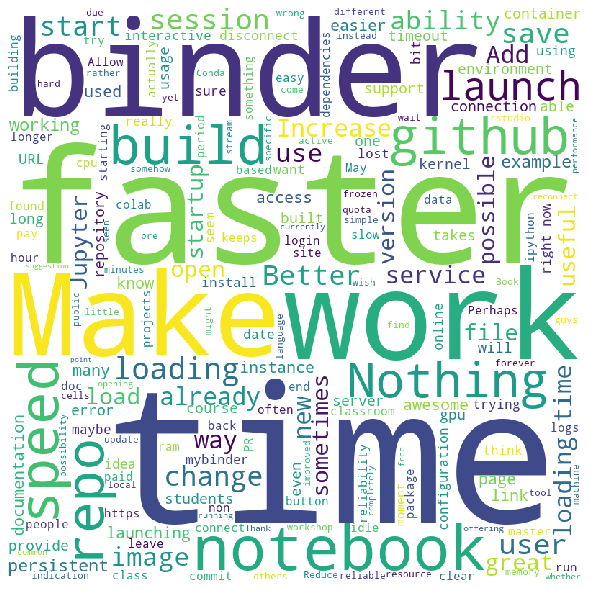

In [3]:
df = pd.read_csv("data/mybinder.org-user-survey-feb-2020.csv")

answer_embs = []

for index, row in df.iterrows():
    answer = row["If you could change one thing about Binder, what would it be?"]
    if type(answer) is str and len(answer)>3:
        answer_emb = nlp(answer).vector
        answer_embs.append([index,answer,answer_emb])
        
comment_words = " ".join([x[1] for x in answer_embs])

wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(comment_words) 
  
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()        

In [4]:
n_clusters = 10

X = np.array([x[2] for x in answer_embs])
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(X)
clusters = {x: {"centroid": kmeans.cluster_centers_[x], "answers":[],"vectors":[]} for x in range(len(kmeans.cluster_centers_))}

for x in range(len(answer_embs)):
    answer = answer_embs[x][1]
    vector = answer_embs[x][2]
    label = kmeans.labels_[x]
    clusters[label]["answers"].append(answer)
    clusters[label]["vectors"].append(vector)

In [5]:
for cluster,infos in clusters.items():
    answers = infos["answers"]
    vectors = infos["vectors"]
    centroid = infos["centroid"]
    comment_words = [word for answer in answers for word in clean_text(answer)]
    most_common = Counter(comment_words).most_common(5)
    central_ids = get_closest_to_centroid(vectors,centroid)
    central_answers = [answers[id_[0]] for id_ in central_ids]
    for answ in central_answers:
        print (answ)
    print ("---> other",len(answers)-len(central_answers),"messages around the same topic")
    
    
#    for answ in answers:
#        print (answ)
    print (" ")

Documentation
An interactive configuration tool
---> other 0 messages around the same topic
 
just an idea -- i'd be willing to pay for a hosted service with more computer and such. ie jupyterhub. probably out of scope but i can wish because you guys do great work! :) binder i think is great because it's simple so i don't have other suggestions right now. 
I'm trying to read a notebook documenting floweaver. https://mybinder.org/v2/gh/ricklupton/floweaver/master?filepath=docs%2Ftutorials%2Fquickstart.ipynb It's very frustrating because if I leave it for a few minutes it disconnects, and won't reconnect. (eg switching to another tab for a while) So I would say, from my sample size of 1, that the basic functionality doesn't seem to work :-(
If it was possible to have the pre-built images launch faster, that would be awesome. Sometimes I wait 5-15 minutes for a binder instance to launch and then when I come to the binder instance, it has already expired. It's one barrier I have convincing

In [6]:
def search_query(q,text):
    # if multiword query
    if len(q.split(" "))>1:
        if q.lower() in answer.lower():
            return True
    else:
        # we lowercase and remove puctuation
        # then search for a perfect match
        text = clean_text(text)
        if q.lower() in text:
            return True

In [7]:
q = 'R'

for index, row in df.iterrows():
    answer = row["If you could change one thing about Binder, what would it be?"]
    if type(answer) is str and len(answer)>3:
        check_relevance = search_query(q,answer)
        if check_relevance is True:
            print (answer+"\n")

If it was possible to have the pre-built images launch faster, that would be awesome. Sometimes I wait 5-15 minutes for a binder instance to launch and then when I come to the binder instance, it has already expired. It's one barrier I have convincing my R friends to try binder instead of shiny-apps.

Make specifying the R version a little more reliable - at the moment even with the new ability to specify the date in the runtime.txt file if I change the date after the image has already been built, when it rebuilds it doesn't seem to use the new, changed date to build with the appropriate version of R but rather keeps the version associated with the original runtime.txt date.

The documentation. It is currently intractable. The examples all look completely different with some using yml and some not and I'm not whether that matters or not. Simple walk throughs for common demands (ipython, Rmarkdown and R notebooks) would be great.

It would be nice to have a more advanced version. For a 